## **Section 2: Exploratory Data Analysis**
---
### **2.1 Statistical Analysis**
---
#### **Task 2.1.1: Descriptive Statistics and Distribution Analysis**
---
**Questions to Investigate**:
---
1. **Revenue Distribution Analysis**
   - What is the shape of the transaction value distribution, and does it follow a power law?
   - What percentage of total revenue comes from the top 10% of customers?
   - How does the coefficient of variation in spending differ across product categories?
---

In [26]:
# imports

import powerlaw
import itertools
%matplotlib inline
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
from typing import Self
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import gaussian_kde, mannwhitneyu, f_oneway, chi2_contingency, levene, t


In [32]:
class EDAAnalysis:
    
    def __init__(self, datapath: str) -> None:
        """
        Initialize the FeatureEngineeringPipeline with input and output file paths.

        Parameters
        ----------
        datapath : str
            Path to the input Parquet file containing raw e-commerce event data.
        savePath : str
            Path where the engineered dataset should be saved.

        Raises
        ------
        Exception
            If the Parquet file cannot be loaded successfully.
        """
        self.datapath = datapath
    
        try:
            self.lazyDf = pl.scan_parquet(datapath)
    
        except Exception as e:
            print(f"Error initializing the raw data analysis: {e}")
            raise
    
    def generateHistogramKDE(self, plotDf: pd.DataFrame, columnName: str, per: str) -> None:
        # Create figure + axis
        fig, ax = plt.subplots(figsize=(10, 6))
        # Histogram
        counts, bins, patches = ax.hist(plotDf[columnName], bins=50,
            edgecolor="black",alpha=0.7,density=True,label="Histogram")

        # Apply colormap to bars based on frequency (height)
        norm = plt.Normalize(counts.min(), counts.max())
        cmap = plt.cm.magma  # Try 'plasma', 'coolwarm', etc.
        for count, patch in zip(counts, patches):
            patch.set_facecolor(cmap(norm(count)))

        # Titles & labels
        ax.set_title(f"Distribution of {columnName} per {per}", fontsize=14, fontweight="bold")
        ax.set_xlabel(f"Number of {columnName} per {per}", fontsize=12)
        ax.set_ylabel("Density", fontsize=12)

        ax.set_xscale("log")
        ax.set_yscale("log")

        # Colorbar (attached to the same axis)
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, label="Density (Normalized Frequency)")

        # Grid, legend, layout
        ax.grid(alpha=0.3, linestyle="--")
        ax.legend()
        plt.tight_layout()
        plt.show()

    def generateBarPlot(self, plotDf, x: str, y: str, title: str, cmap: str = "magma") -> None:

        # Extract values
        values = plotDf[y].to_numpy()  
        norm = plt.Normalize(values.min(), values.max())
        colors = plt.cm.get_cmap(cmap)(norm(values))

        # Create figure + axis
        fig, ax = plt.subplots(figsize=(12, 6))
        bars = ax.bar(plotDf[x], plotDf[y], color=colors, edgecolor="black")

        ax.set_xticklabels(plotDf[x], rotation=45, ha="right")
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title(title)
        ax.grid(axis="y", linestyle="--", alpha=0.6)

        # Add colorbar and attach it to the current axis
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, label=f"{y} intensity")

        plt.tight_layout()
        plt.show()

        return ax

    def generateBoxPlot(self, plotDf: pd.DataFrame, column: str, title: str, log_scale: bool = False, ylim: tuple = None):
        plt.figure(figsize=(10, 6))
        plt.boxplot(
            plotDf[column],
            vert=True,
            patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="black"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black"),
            flierprops=dict(marker="o", color="black", alpha=0.5)
        )
        plt.title(title)
        plt.ylabel(column)

        if log_scale:
            plt.yscale("log")

        if ylim is not None:  # allow manual zooming
            plt.ylim(ylim)

        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

    def comparePowerLaw(self, plotDf: pd.DataFrame, columnName: str) -> None:
        # --- Distribution Fitting ---
        values = plotDf[columnName].values
        values = values[values > 0]  # remove zeros/negatives

        fit = powerlaw.Fit(values, discrete=False, verbose=False)

        # Likelihood ratio test: power-law vs lognormal
        R, p = fit.distribution_compare('power_law', 'lognormal')

        print(f"Power-law alpha: {fit.power_law.alpha:.3f}, xmin: {fit.power_law.xmin}")
        print(f"Log-likelihood ratio (R): {R:.3f}, p-value: {p:.3f}")
        if R > 0 and p < 0.05:
            print("→ Power law fits significantly better")
        elif R < 0 and p < 0.05:
            print("→ Lognormal fits significantly better")
        else:
            print("→ No clear winner")

        # --- Plot CCDF with fits ---
        fig = fit.plot_ccdf(linewidth=2, color='black', label="Empirical CCDF")
        fit.power_law.plot_ccdf(ax=fig, color='red', linestyle='--', label="Power law fit")
        fit.lognormal.plot_ccdf(ax=fig, color='blue', linestyle='--', label="Lognormal fit")

        plt.xlabel(f"{columnName}")
        plt.ylabel("CCDF (P(X ≥ x))")
        plt.title(f"{columnName} Distribution Fit")
        plt.legend()
        plt.grid(alpha=0.3, linestyle="--")
        plt.show()

    def transactionValueDistribution(self, sampleSize: int = 1000) -> None:
        transcations = self.lazyDf.group_by('user_id').agg([pl.col('price').sum().alias('transcationsValue')])
        transcations = transcations.collect().to_pandas()
        if len(transcations) > sampleSize:
            transcations = transcations.sample(sampleSize, random_state=42)
        transcationsNotGrouped = self.lazyDf.select(pl.col("price")).collect().to_pandas()
        self.generateHistogramKDE(transcations, 'transcationsValue', 'user')
        self.generateHistogramKDE(transcationsNotGrouped, 'price', 'user')
        self.comparePowerLaw(transcations, 'transcationsValue')
    
    def transcationLorenzCurve(self,) -> None:
        transcations = (
            self.lazyDf.group_by('user_id')
            .agg([pl.col('price').sum().alias('priceCumSum')])
            .collect().to_pandas()
        )

        transcations.sort_values(ascending=True, by='priceCumSum', inplace=True)
        n = len(transcations)
        totalSum = np.sum(transcations['priceCumSum'])
        cummData = np.cumsum(transcations['priceCumSum']) / totalSum
        cummData = np.insert(cummData, 0, 0)  # Start at origin (0,0)

        userProportions = np.linspace(0, 1, n+1)

        # Plot Lorenz curve
        plt.plot(userProportions, cummData, label='Lorenz Curve')

        # Equality line
        plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfect Equality')

        # Compute Gini coefficient
        gini = 1 - 2 * np.trapezoid(cummData, userProportions)

        # Annotate Gini on plot
        plt.text(
            0.6, 0.2, f"Gini = {gini:.2f}",
            fontsize=12, bbox=dict(facecolor="white", alpha=0.6)
        )

        # Labels, legend, grid
        plt.xlabel('Cumulative Customers')
        plt.ylabel('cumulative Revenue')
        plt.title('Lorenz Curve')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plotTopNRevenueCurve(self, customersRevenue, topN: float, topCustomersShare: float) -> None:
    
        if isinstance(customersRevenue, pl.DataFrame):
            customersRevenue = customersRevenue.to_pandas()

        totalRevenue = customersRevenue["customerRevenue"].sum()
        customersRevenue["cumulativeRevenueShare"] = customersRevenue["customerRevenue"].cumsum() / totalRevenue
        n = len(customersRevenue)
        customersRevenue["cumulativeCustomerShare"] = np.arange(1, n + 1) / n

        plt.figure(figsize=(10, 6))
        plt.plot(
            customersRevenue["cumulativeCustomerShare"],
            customersRevenue["cumulativeRevenueShare"],
            label="Cumulative Revenue Curve",
            color="blue", linewidth=2
        )

        plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Line of Equality")

        cutoff_idx = int(topN * n)
        cutoff_x = customersRevenue["cumulativeCustomerShare"].iloc[cutoff_idx]
        cutoff_y = customersRevenue["cumulativeRevenueShare"].iloc[cutoff_idx]

        plt.axvline(x=cutoff_x, color="gray", linestyle=":")
        plt.axhline(y=cutoff_y, color="gray", linestyle=":")
        plt.text(cutoff_x, cutoff_y,
                f"Top {int(topN*100)}% → {topCustomersShare:.2f}%",
                fontsize=10, va="bottom", ha="right")

        plt.title(f"Cumulative Revenue Curve (Top {int(topN*100)}% Highlighted)",
                fontsize=14, fontweight="bold")
        plt.xlabel("Cumulative Share of Customers")
        plt.ylabel("Cumulative Share of Revenue")
        plt.legend()
        plt.grid(alpha=0.3, linestyle="--")
        plt.tight_layout()
        plt.show()

    def calculateTopNCustomersRevenue(self, topN: float = 0.1) -> None:
        customersRevenue = (
            self.lazyDf.group_by('user_id')
            .agg(pl.col('price').sum().alias("customerRevenue"))
            .sort(pl.col('customerRevenue'), descending=True)
            .collect()
        )

        uniqueCustomersTotal = customersRevenue.height
        topNCustomersTotal = int(topN * uniqueCustomersTotal)

        customersRevenueSum = customersRevenue.select(pl.col('customerRevenue')).to_series().sum()
        topCustomersSum = customersRevenue.head(topNCustomersTotal).select(pl.col('customerRevenue')).to_series().sum()

        topCustomersShare = (topCustomersSum / customersRevenueSum) * 100

        print(f"The revenue percentage of the top {topN*100:.0f}% customers is {topCustomersShare:.2f}%")
        self.plotTopNRevenueCurve(customersRevenue, topN, topCustomersShare)
    
    def calculateCoefficientOfVariation(self) -> None:
        userCatRevenue = self.lazyDf.group_by(['category_l1', 'user_id']).agg([pl.col('price').sum().alias('revenueSum')])
        userCatRevenue = userCatRevenue.group_by('category_l1').agg([pl.col('revenueSum').mean().alias('revenueMean'), pl.col('revenueSum').std().alias('revenueSTD')])
        userCatRevenue = userCatRevenue.with_columns([(pl.col('revenueSTD')/pl.col('revenueMean')).alias('coefficientOfVariation')])
        userCatRevenue = userCatRevenue.select([pl.col('category_l1', 'coefficientOfVariation')]).sort(by=pl.col('coefficientOfVariation'), descending=True).collect()
        print(userCatRevenue.head(userCatRevenue.height))
        self.generateBarPlot(plotDf=userCatRevenue, x='category_l1', y='coefficientOfVariation', title="Revenue Volatility by Category (Coefficient of Variation)")
    
    def calculateSessionDurationStatistics(self) -> None:
        sessionDurations = self.lazyDf.select(pl.col("sessionDuration")).collect().to_pandas()
        sessionDurationsNoOutliers = self.lazyDf.filter(pl.col('isMultiDaySession') == False).select(pl.col('sessionDuration')).collect().to_pandas()

        self.generateBoxPlot(sessionDurations, column="sessionDuration", title="Session Duration Distribution")
        self.generateBoxPlot(sessionDurations, column="sessionDuration", title="Session Duration Distribution (Log Scale)", log_scale=True)
        self.generateBoxPlot(sessionDurationsNoOutliers, column="sessionDuration", title="Session Duration Distribution (Excluding Multi-Day Sessions)", ylim=(0, 2))
    
    def customersSegmentationPerSession(self) -> None:
        customersSegments = self.lazyDf.group_by('user_id').agg([ pl.when((pl.col('isMultiDaySession') == True) & (pl.col('event_type') == 'purchase')).
                                                                 then(True).otherwise(False).any().alias("isPowerUser"),
                                                                  pl.when((pl.col('isMultiDaySession') == False) & (pl.col('event_type') == 'purchase')).
                                                                  then(True).otherwise(False).any().alias("isQuickBuyer"),
                                                                  pl.when((pl.col('isMultiDaySession') == True) & (pl.col('event_type') != 'purchase')).
                                                                  then(True).otherwise(False).any().alias("isBrowserOrBot"),
                                                                  pl.when((pl.col('isMultiDaySession') == False) & (pl.col('event_type') != 'purchase')).
                                                                  then(True).otherwise(False).any().alias("isDisengagedUser")])
        segmentCounts = customersSegments.select([
            pl.col("isPowerUser").sum().alias("Power Users"),
            pl.col("isQuickBuyer").sum().alias("Quick Buyers"),
            pl.col("isBrowserOrBot").sum().alias("Browsers/Bots"),
            pl.col("isDisengagedUser").sum().alias("Disengaged Users"),
        ]).collect().to_pandas().melt(var_name="Segment", value_name="User Count")
        print(segmentCounts)
        self.generateBarPlot(
            plotDf=segmentCounts,
            x="Segment",
            y="User Count",
            title="Customer Segmentation by Session Type",
            cmap="magma"
        )
        
    def estimateWeekdayVsWeekendBehavior(self) -> None:
        weekendEventCount = self.lazyDf.filter(pl.col('isWeekendSession')).\
        group_by('user_session').agg([pl.col('event_type').count().alias('eventCount')]).collect().to_pandas()

        weekdayEventCount = self.lazyDf.filter(pl.col('sessionDayOfWeek').is_in(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])).\
        group_by('user_session').agg([pl.col('event_type').count().alias('eventCount')]).collect().to_pandas()

        stat, pValue = mannwhitneyu(weekdayEventCount['eventCount'], weekendEventCount['eventCount'], alternative="two-sided")
        print("Mann-Whitney U statistic:", stat)
        print("p-value:", pValue)

        # Interpret result
        alpha = 0.05
        if pValue < alpha:
            print("Reject H0: The distributions are different.")
        else:
            print("Fail to reject H0: No significant difference found.")
        
        self.generateBoxPlot(weekdayEventCount, 'eventCount', 'Distribution of events count for weekday sessions', log_scale=True)
        self.generateBoxPlot(weekendEventCount, 'eventCount', 'Distribution of events count for weekend sessions', log_scale=True)

    def calculateProductsVariance(self) -> None:
        productConv = self.lazyDf.filter(pl.col('category_l1') != 'unknown')
        productConv = (
        productConv
        .group_by("product_id", "category_l1")
        .agg([
            (pl.col("event_type") == "purchase").sum().alias("purchaseCount"),
            (pl.col("event_type") == "view").sum().alias("viewCount"),
        ])
        .with_columns([
            pl.when(pl.col("viewCount") > 0)
            .then(pl.col("purchaseCount") / pl.col("viewCount"))
            .otherwise(0)
            .alias("productConversionRate")
        ])
        )

        varianceByCategory = (
            productConv
            .group_by("category_l1")
            .agg(pl.var("productConversionRate").alias("conversionVariance"))
            .sort("conversionVariance", descending=True)
        ).collect()
        print(varianceByCategory.head(varianceByCategory.height))
        self.generateBarPlot(varianceByCategory.to_pandas(), 'category_l1', 'conversionVariance', 'Category vs ConversionVariance')
    
    def CorrelationBetweenViewAndPurchaseEvents(self) -> None:
        eventCount = (
            self.lazyDf
            .group_by("product_id")
            .agg([
                (pl.col("event_type") == "purchase").sum().alias("purchaseCount"),
                (pl.col("event_type") == "view").sum().alias("viewCount"),
            ])
        ).collect().to_pandas()
        corrValue = eventCount.corr(method="spearman")
        print(f"The correlation value between purchase event and view event per product is:\n{corrValue}")

    def anovaCategoryConversionRate(self) -> None:
        # Step 1: Prepare data
        productConv = self.lazyDf.filter(pl.col('category_l1') != 'unknown')
        productConv = (
            productConv
            .group_by("product_id", "category_l1")
            .agg([
                (pl.col("event_type") == "purchase").sum().alias("purchaseCount"),
                (pl.col("event_type") == "view").sum().alias("viewCount"),
            ])
            .with_columns([
                pl.when(pl.col("viewCount") > 0)
                .then(pl.col("purchaseCount") / pl.col("viewCount"))
                .otherwise(0)
                .alias("productConversionRate")
            ])
        ).collect().to_pandas()

        # Step 2: Build groups
        groups = [grp["productConversionRate"].values 
                  for _, grp in productConv.groupby("category_l1")]

        # Step 3: Levene’s test for equal variances
        stat, p = levene(*groups)
        print(f"Levene’s Test: Statistic={stat:.4f}, p-value={p:.4e}")

        alpha = 0.05
        if p >= alpha:
            print(" Variances are equal → using classical ANOVA")
            fStat, pValue = f_oneway(*groups)
            print(f"ANOVA F-statistic = {fStat:.4f}, p-value = {pValue:.4e}")
        else:
            print(" Variances differ → using Welch’s ANOVA")
            welch = anova_oneway(productConv['productConversionRate'], 
                                 groups=productConv['category_l1'], 
                                 use_var="unequal", 
                                 welch_correction=True)
            print(f"Welch’s ANOVA: statistic={welch.statistic:.4f}, p-value={welch.pvalue:.4e}")

            if welch.pvalue < alpha:
                print("Reject H0: At least one category differs.")

    def testSigCartAddingVsPurchase(self) -> None:
        eventsCollected = self.lazyDf.select([pl.col('advancedToCart'), pl.col('advancedToPurchase')]).collect().to_pandas()

        contingency_table = pd.crosstab(eventsCollected["advancedToCart"], eventsCollected["advancedToPurchase"])
        print("Contingency Table:")
        print(contingency_table)

        chi2, pValue, dof, expected = chi2_contingency(contingency_table)

        print("\nChi-Square Test Results:")
        print(f"Chi2 Statistic = {chi2:.4f}")
        print(f"Degrees of Freedom = {dof}")
        print(f"P-Value = {pValue:.4f}")

        print("\nExpected Frequencies:")
        print(pd.DataFrame(expected, 
                        index=contingency_table.index, 
                        columns=contingency_table.columns))
        alpha = 0.05
        if pValue < alpha:
            print("Reject H0: The distributions are different.")
        else:
            print("Fail to reject H0: No significant difference found.")
    
    def correlationBetweenLikelihoodPurchaseAndPrice(self) -> None:
        eventsCount = (
            self.lazyDf
            .group_by("product_id")
            .agg([
                (pl.col("event_type") == "view").sum().alias("viewCount"),
                (pl.col("event_type") == "cart").sum().alias("cartCount"),
                pl.col("price").median().alias("medianPrice")
            ])
        )

        eventCount = eventsCount.with_columns(
            (pl.col("cartCount") / pl.col("viewCount")).alias("cartLikelihood")
        ).filter(pl.col("viewCount") > 0) 

        df = eventCount.select(["medianPrice", "cartLikelihood"]).collect().to_pandas()

        corr_value = df["medianPrice"].corr(df["cartLikelihood"], method="spearman")

        print(f"The Spearman correlation between product price and cart likelihood is: {corr_value:.4f}")
    
    def testSessionStartVsPurchase(self) -> None:
        sessionStartPurchase = self.lazyDf.select([pl.col('sessionStartHour'),pl.col('has_purchase')]).collect().to_pandas()
        contingencyTable = pd.crosstab(sessionStartPurchase["sessionStartHour"], sessionStartPurchase["has_purchase"])
        chi2, pValue, dof, expected = chi2_contingency(contingencyTable)

        print("\nChi-Square Test Results:")
        print(f"Chi2 Statistic = {chi2:.4f}")
        print(f"Degrees of Freedom = {dof}")
        print(f"P-Value = {pValue:.4f}")

        alpha = 0.05
        if pValue < alpha:
            print("Reject H0: The distributions are different.")
        else:
            print("Fail to reject H0: No significant difference found.")
        
        n = contingencyTable.values.sum()   # total sample size
        k = min(contingencyTable.shape) - 1 # smaller dimension - 1
        cramers_v = (chi2 / (n * k)) ** 0.5
        residuals = (contingencyTable - expected) / np.sqrt(expected)
        print("\nCramér's V (effect size):", round(cramers_v, 4))
        print("\nStandardized Residuals:")
        print(residuals)

    def anovaSessionHourVsConversionRate(self) -> None:
        # Prepare data
        sessionData = self.lazyDf.select(["sessionStartHour", "has_purchase"]).collect().to_pandas()

        groups = [grp["has_purchase"].values 
                for _, grp in sessionData.groupby("sessionStartHour")]

        # Step 1: Levene’s Test
        stat, pLevene = levene(*groups)
        print("\nLevene’s Test for Equal Variances")
        print(f"Statistic = {stat:.4f}, p-value = {pLevene:.4e}")

        alpha = 0.05
        if pLevene >= alpha:
            #  Equal variances → use classical ANOVA
            fStat, pValue = f_oneway(*groups)
            print("\nANOVA Test: Session Start Hour vs Conversion Rate")
            print(f"F-statistic = {fStat:.4f}")
            print(f"p-value = {pValue:.4e}")

            if pValue < alpha:
                print("Reject H0: At least one hour has a significantly different conversion rate.")

        else:
            #  Variances differ → use Welch’s ANOVA
            print("\n Variances are significantly different → using Welch’s ANOVA instead")
            welch_result = anova_oneway(
                sessionData['has_purchase'], 
                sessionData['sessionStartHour'], 
                use_var='unequal'
            )
            print(welch_result)

    def productCooccurrencePatterns(self):
        # Step 1: Session → product list
        sessionProducts = (
            self.lazyDf
            .filter(pl.col("event_type").is_in(["view", "purchase"]))
            .select(["user_session", "product_id"])
            .unique(["user_session", "product_id"])
            .group_by("user_session")
            .agg(pl.concat_list("product_id").alias("products"))
            .collect()
        )

        # Convert to Python lists so iteration works
        productLists = sessionProducts["products"].to_list()

        # Step 2: Build product pairs in Python
        pairs = []
        for products in productLists:
            if len(products) > 1:
                for a, b in itertools.combinations(sorted(products), 2):
                    pairs.append((a, b))

        # Step 3: Back to Polars → count pairs
        pairsDF = pl.DataFrame(pairs, schema=["product_id", "product_id_right"])
        nAB = (
            pairsDF
            .group_by(["product_id", "product_id_right"])
            .len()
            .rename({"len": "nAB"})
        )

        print(nAB.head(10))


        

## **Task 2.1.1 – Descriptive Statistics & Distribution Analysis (Deep Dive: Q1–Q3)**

---

### 1. What is the shape of the transaction value distribution, and does it follow a power law?

In e-commerce, transaction values are rarely uniform — they are typically **skewed with heavy tails**. A small subset of transactions (luxury items, bulk orders) often dominate the revenue, while most purchases cluster in the low-to-mid range.

To properly characterize this, we examine whether the distribution follows a **power law** (a hallmark of highly unequal systems) or if an alternative such as **lognormal** provides a better fit.

**Distribution Analysis Strategy:**

* **Step 1:** Plot transaction values on a **log-log scale** to visually assess whether the tail exhibits linear behavior (indicative of a power law).
* **Step 2:** Fit both **power-law** and **lognormal** distributions and compare fit quality using likelihood ratios or KS tests.
* **Step 3:** Quantify inequality with **Lorenz curves** and the **Gini coefficient**, which summarize concentration of revenue in the hands of few transactions.

Formula for Gini coefficient:

$$
G = \frac{\sum_{i=1}^n \sum_{j=1}^n |x_i - x_j|}{2n^2 \bar{x}}
$$

This dual approach (distribution fit + inequality measures) ensures we don’t just describe the shape, but also its **business implication**: high inequality means revenue is driven by a minority of big-ticket items.

---




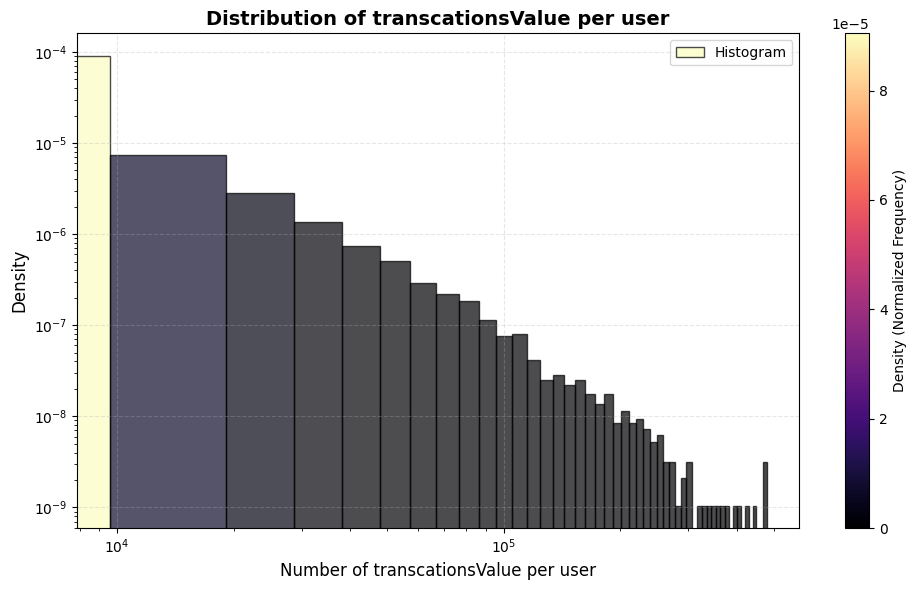

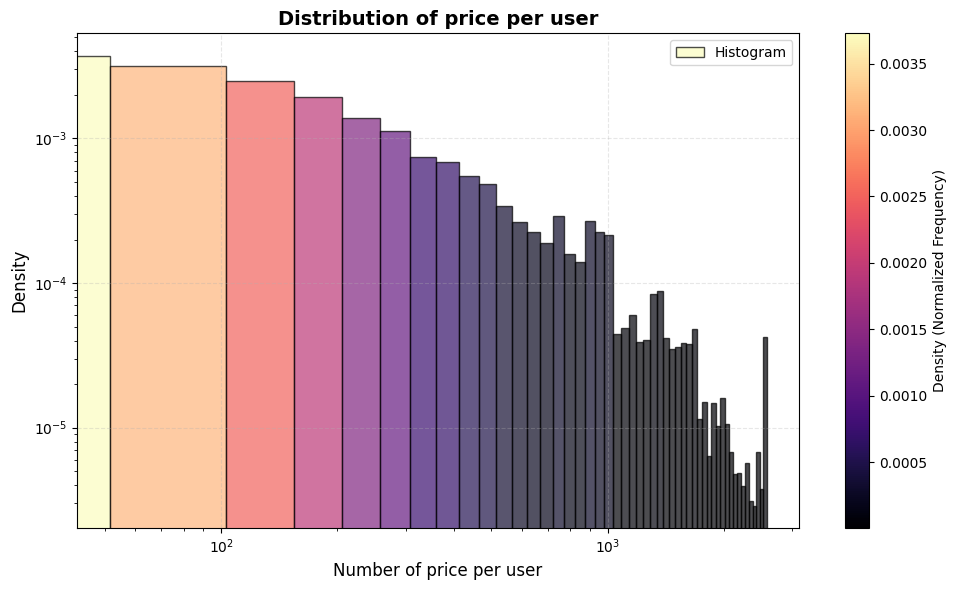

Power-law alpha: 3.355, xmin: 70369.390625
Log-likelihood ratio (R): -4.829, p-value: 0.043
→ Lognormal fits significantly better


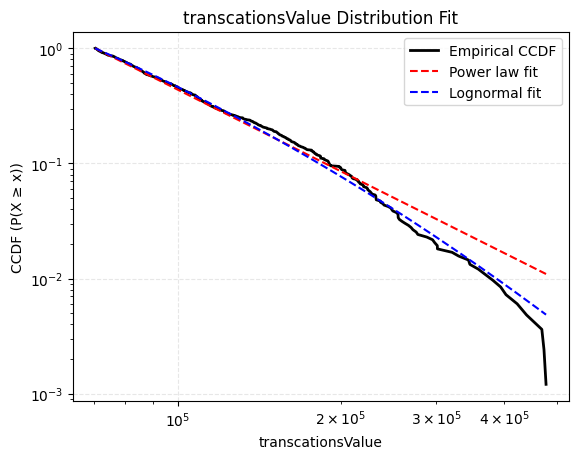

In [5]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.transactionValueDistribution(sampleSize=100000)
del analysis

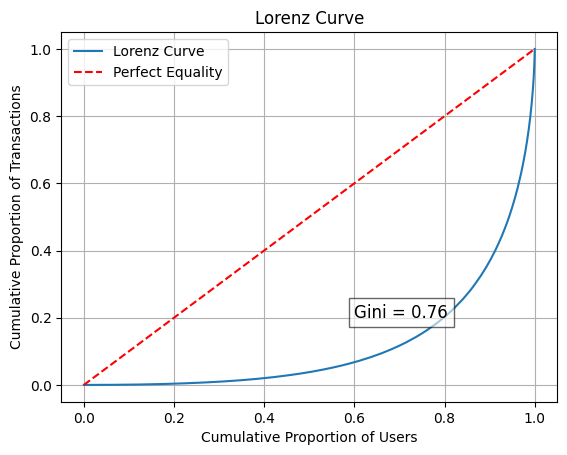

In [43]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.transcationLorenzCurve()
del analysis

---

### 2. What percentage of total revenue comes from the top 10% of customers?

Customer spending is rarely evenly distributed — a few high-value customers often dominate revenue streams. Identifying them is critical for **customer lifetime value (CLV) analysis** and **VIP segmentation**.

**Revenue Concentration Strategy:**

* **Step 1:** Rank customers by total spending over the dataset.
* **Step 2:** Compute cumulative revenue contribution across ranked customers.
* **Step 3:** Identify the revenue share of the **top 10% of customers**.

Formula for top-decile revenue share:

$$
\text{TopDecileShare} = \frac{\sum_{i \in \text{Top 10\%}} R_i}{\sum_{j=1}^N R_j}
$$

Where $R_i$ is revenue from customer $i$.

If this percentage is very high (e.g., >70%), it suggests the business is **overly dependent on a small elite group**. This aligns with Pareto’s principle (80/20 rule), but quantification provides clarity — whether the actual concentration is **sustainable (diverse base)** or **risky (over-reliant on few customers)**.

---



The revenue percentage of the top 10% customers is 63.18%


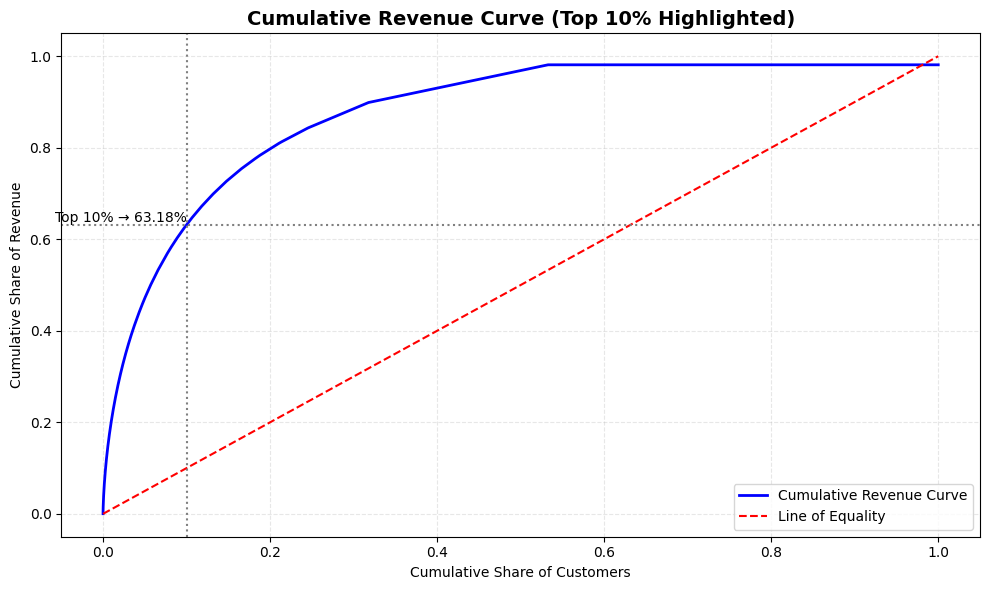

In [30]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.calculateTopNCustomersRevenue()
del analysis

---

### 3. How does the coefficient of variation in spending differ across product categories?

Not all product categories contribute revenue in the same way. Some categories are **stable (low variance)**, meaning most customers spend similarly, while others are **volatile (high variance)**, dominated by rare but very large transactions.

**Category Variability Strategy:**

* **Step 1:** Aggregate revenue at the customer–category level.
* **Step 2:** For each category, compute mean spending, standard deviation, and the **coefficient of variation (CV)**.

Formula for CV:

$$
CV = \frac{\sigma}{\mu}
$$

* **Step 3:** Compare CV across categories to identify:

  * **Stable categories** (low CV) → predictable revenue streams.
  * **Volatile categories** (high CV) → riskier but potentially high-reward markets.

This distinction helps Marcus prioritize marketing and supply-chain strategies. Stable categories can be **optimized for efficiency**, while volatile categories may require **targeted promotions or bundling** to smooth out revenue unpredictability.

---

**Summary Principle (Q1–Q3):**
Together, these first three questions uncover **where revenue inequality originates**. We start at the **transaction level** (distribution shape), move up to the **customer level** (top-decile revenue dominance), and finally zoom out to the **category level** (variability of spending). This layered approach ensures we capture not only statistical distributions but also **actionable business insights** on dependency risks, category stability, and customer concentration.

shape: (14, 2)
┌──────────────┬────────────────────────┐
│ category_l1  ┆ coefficientOfVariation │
│ ---          ┆ ---                    │
│ str          ┆ f32                    │
╞══════════════╪════════════════════════╡
│ kids         ┆ 6.627834               │
│ stationery   ┆ 3.975363               │
│ construction ┆ 3.68598                │
│ unknown      ┆ 3.355511               │
│ sport        ┆ 3.346963               │
│ …            ┆ …                      │
│ apparel      ┆ 2.741142               │
│ auto         ┆ 2.654524               │
│ electronics  ┆ 2.491912               │
│ country_yard ┆ 2.343213               │
│ medicine     ┆ 1.902237               │
└──────────────┴────────────────────────┘


C:\Users\negam\AppData\Local\Temp\ipykernel_18160\2185611034.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(values))
C:\Users\negam\AppData\Local\Temp\ipykernel_18160\2185611034.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plotDf[x], rotation=45, ha="right")


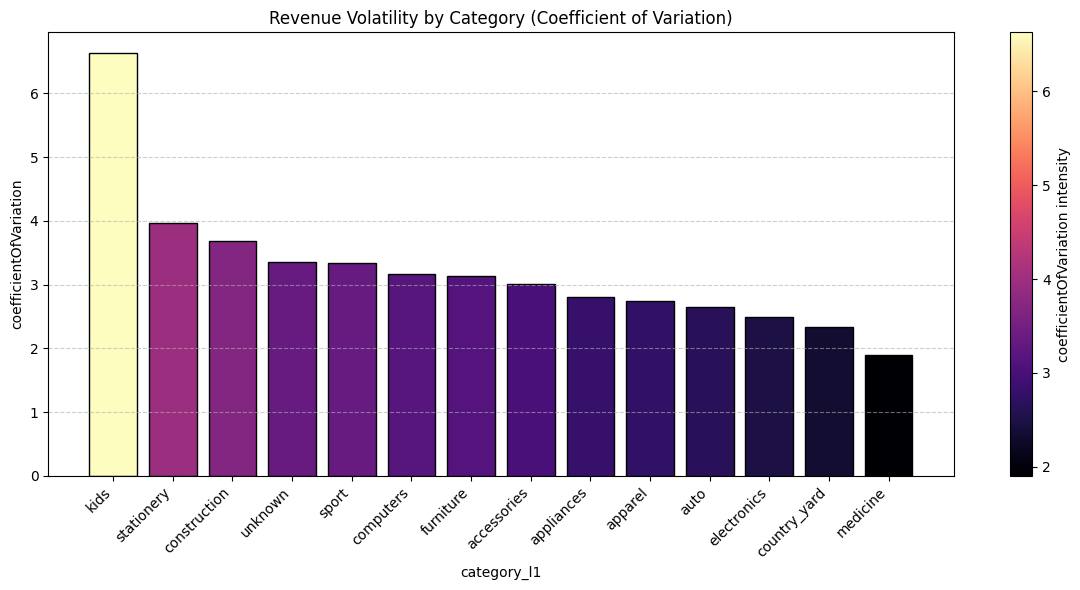

In [22]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.calculateCoefficientOfVariation()
del analysis

---

2. **Customer Behavior Patterns**
   - What is the mean and median session duration, and what does the skewness tell us about user engagement?
   - How does the distribution of events per session vary by customer geography?
   - What statistical test can confirm if weekend shopping behavior significantly differs from weekday behavior?




---

## **Task 2.1.1 – Descriptive Statistics & Distribution Analysis (Deep Dive: Q1–Q3)**

---

### **1. Mean and median session duration, and skewness interpretation**

In e-commerce, session durations are typically **right-skewed**, with most users having short-to-moderate sessions and a small fraction having very long sessions (either power users or bots). Mean and median reveal central tendencies, while skewness indicates asymmetry and potential outliers.

**Analysis Strategy:**



* **Step 1:** Compute **mean, median, and skewness** to understand distribution shape.
* **Step 2:** Identify and classify **outliers**:

  * Long sessions **with purchases** → power users
  * Long sessions **without purchases** → bots (exclude from further analysis)
* **Step 3:** Recompute statistics on cleaned sessions to represent true engagement.
* **Step 4:** Segment users for BI actions:

  * Power Users: high duration + purchase
  * Quick Buyers: low duration + purchase
  * Browsers: high duration + no purchase
  * Disengaged Users: low duration + no purchase

**Business Insight:** Helps identify the **top engaged customers** for retention campaigns and separate bot traffic from actionable data.

---






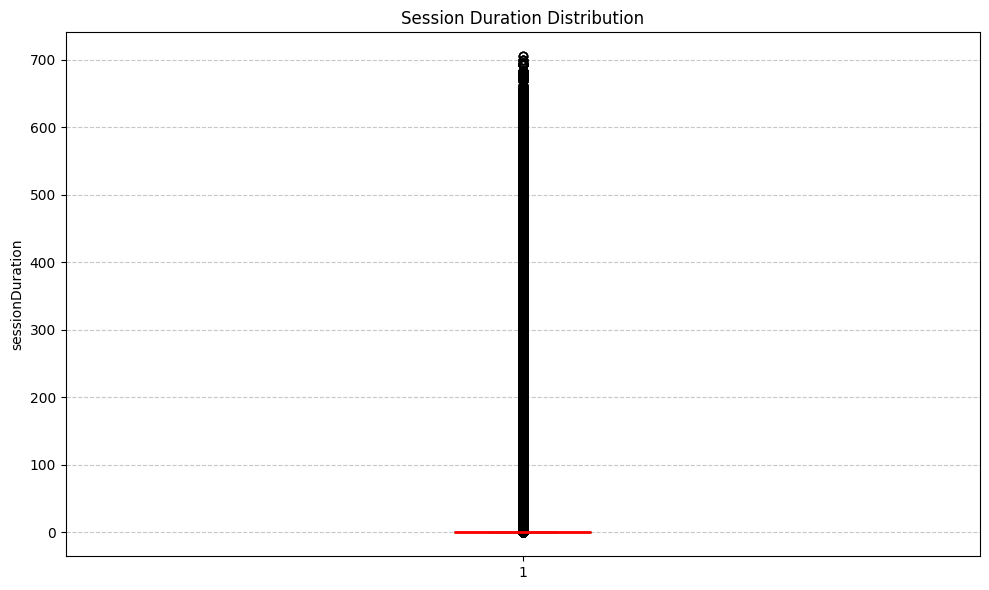

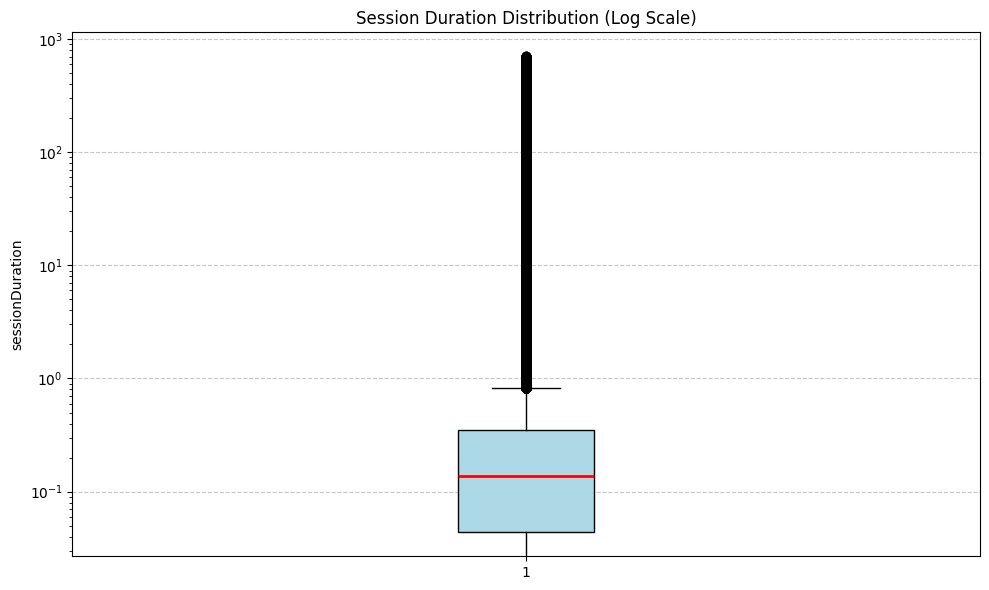

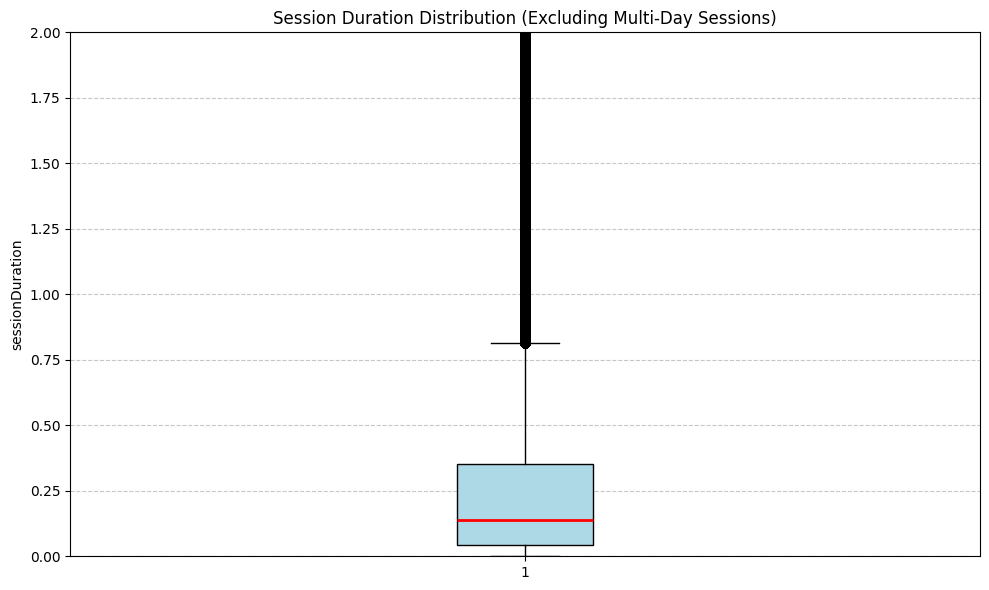

In [23]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.calculateSessionDurationStatistics()
del analysis

            Segment  User Count
0       Power Users          94
1      Quick Buyers      441592
2     Browsers/Bots       18523
3  Disengaged Users     3691454


C:\Users\negam\AppData\Local\Temp\ipykernel_18160\316805312.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(values))
C:\Users\negam\AppData\Local\Temp\ipykernel_18160\316805312.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plotDf[x], rotation=45, ha="right")


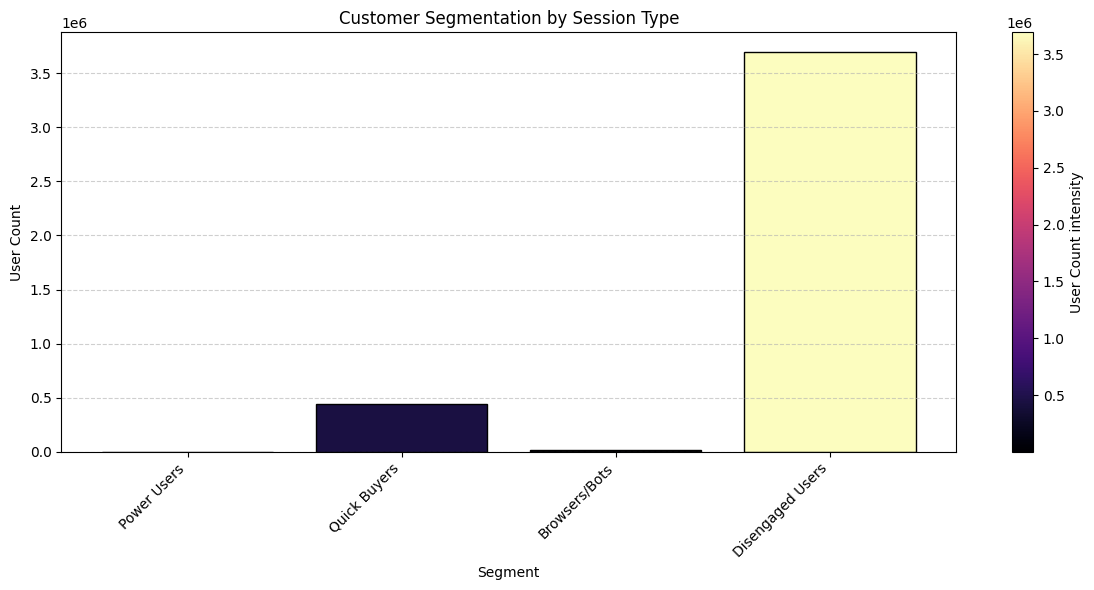

In [30]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.customersSegmentationPerSession()
del analysis

---
### **2. Distribution of events per session by geography (not applicable)**

The original task intends to explore how **session engagement varies by location**, but the dataset **does not contain geographical information**.

**Adaptation Strategy:**

* **Step 1:** Document the limitation clearly in your analysis:

> “Analysis of events per session by customer geography is not possible due to missing location data.”

* **Step 2:** Suggest alternative dimensions for segmentation (if available), e.g., **device type, category, or session type**.
* **Step 3:** Ensure downstream insights **do not assume geography**, maintaining transparency in BI reporting.

**Business Insight:** Demonstrates **critical thinking** and adherence to data limitations while still providing actionable user engagement insights.

---

### **3. Weekend vs weekday session behavior**

Understanding whether user activity differs between **weekends and weekdays** informs marketing timing, promotions, and operational planning. In skewed datasets like session/event counts, traditional parametric tests (t-test) are unreliable.

**Statistical Testing Strategy:**

* **Step 1:** Label each session as `weekday` or `weekend` based on `event_time`.
* **Step 2:** Aggregate **number of events per session**.
* **Step 3:** Since data is skewed, use **Mann-Whitney U test** to test if weekend and weekday distributions differ significantly.
* **Step 4:** Visualize distributions using **boxplots or KDEs** for intuitive comparison.

**Business Insight:** Confirms whether weekend behavior is measurably different, guiding **campaign scheduling, ad spend, and inventory optimization** during peak periods.

---


Mann-Whitney U statistic: 19421770390385.0
p-value: 0.0
Reject H0: The distributions are different.


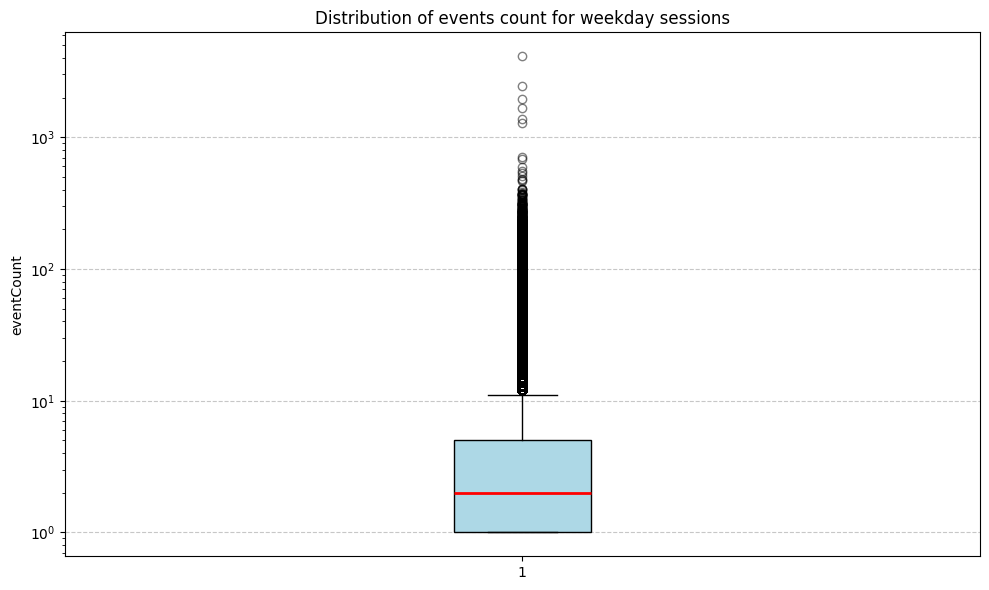

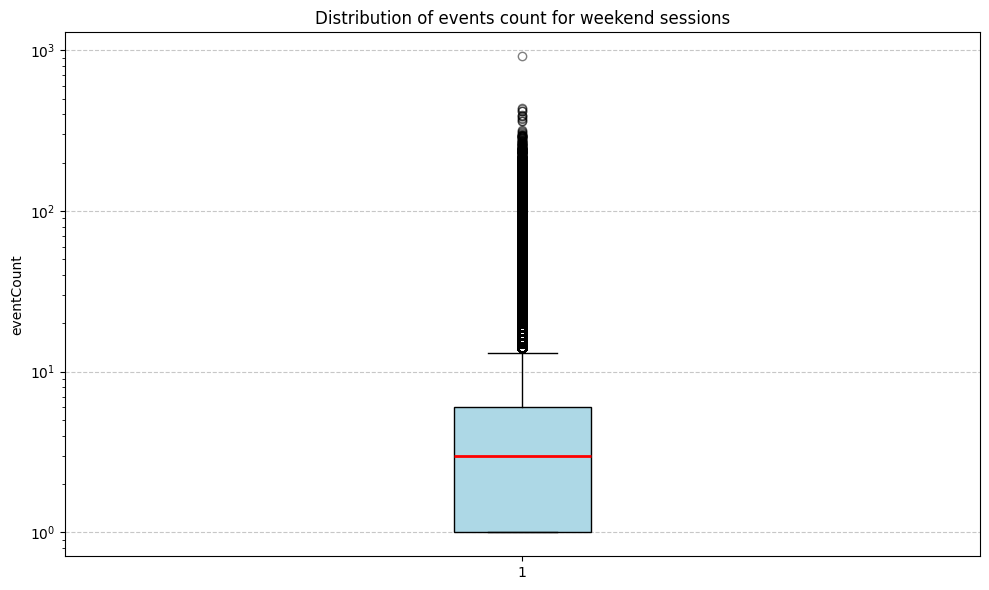

In [15]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.estimateWeekdayVsWeekendBehavior()
del analysis

---
3. **Product Performance Metrics**
   - Which product categories show the highest variance in individual product performance?
   - What is the correlation coefficient between product views and actual purchases?
   - How do we test for statistical significance in conversion rate differences between categories?




---

## **Task 2.1.1 – Descriptive Statistics & Distribution Analysis (Deep Dive: Q4–Q6)**

---

### **4. Which product categories show the highest variance in individual product performance?**

In e-commerce, not all products in a category perform equally. Some categories contain a mix of **blockbuster products and underperformers**, while others are more consistent. High variance within a category can highlight areas where targeted **marketing, inventory adjustments, or optimization** may be needed.

**Variance Analysis Strategy:**

* **Step 1:** Use the engineered feature `categoryConversionRate` per product to measure individual performance.
* **Step 2:** Filter out `isExtremeOutlier` and `isAbnormal` products to avoid distortion from anomalous values.
* **Step 3:** Aggregate by category (`category_l1` or `category_l2`) and calculate **variance of conversion rates**.
* **Step 4:** Rank categories to identify those with the **highest variability**.

**Business Implication:**
High variance indicates a **mixed portfolio** — a few products drive most of the revenue. Actions may include promoting underperformers, reallocating inventory, or optimizing pricing. Low variance indicates a **stable category**, suitable for consistent campaigns and scaling promotions.

---








shape: (13, 2)
┌──────────────┬────────────────────┐
│ category_l1  ┆ conversionVariance │
│ ---          ┆ ---                │
│ str          ┆ f64                │
╞══════════════╪════════════════════╡
│ stationery   ┆ 0.000358           │
│ appliances   ┆ 0.00027            │
│ furniture    ┆ 0.000223           │
│ kids         ┆ 0.000176           │
│ auto         ┆ 0.000168           │
│ …            ┆ …                  │
│ sport        ┆ 0.000099           │
│ apparel      ┆ 0.000095           │
│ medicine     ┆ 0.000069           │
│ construction ┆ 0.000068           │
│ country_yard ┆ 0.000029           │
└──────────────┴────────────────────┘


C:\Users\negam\AppData\Local\Temp\ipykernel_4900\238013043.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(values))
C:\Users\negam\AppData\Local\Temp\ipykernel_4900\238013043.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plotDf[x], rotation=45, ha="right")


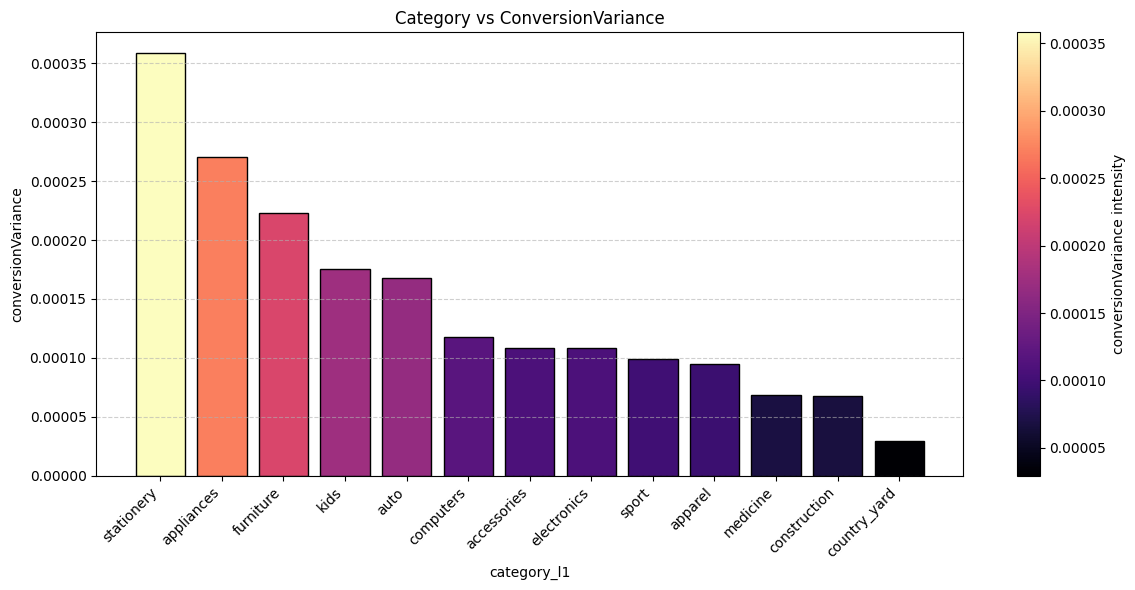

In [34]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.calculateProductsVariance()
del analysis

---
### **5. What is the correlation coefficient between product views and actual purchases?**

Understanding how user **interest translates into sales** is crucial. Products with many views but few purchases may signal **UX, pricing, or appeal issues**, while high correlation indicates effective conversion of interest into revenue.

**Correlation Analysis Strategy:**

* **Step 1:** Aggregate `event_type` per product to calculate:

  * `views` → user interest
  * `purchases` → actual conversions
* **Step 2:** Calculate **correlation coefficient**:

  * Use **Pearson correlation** for roughly linear relationships
  * Use **Spearman correlation** for skewed or non-linear distributions
* **Step 3:** Interpret results:

  * High positive correlation → high interest translates to purchases; focus on scaling these products
  * Low correlation → investigate product page, pricing, or UX to improve conversion

**Business Implication:**
Identifies **high-converting products** for promotions and flags **products needing intervention** to maximize revenue from user engagement.

---

In [ ]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.CorrelationBetweenViewAndPurchaseEvents()
del analysis

The correlation value between purchase event and view event per product is:
               product_id  purchaseCount  viewCount
product_id       1.000000      -0.173581  -0.201345
purchaseCount   -0.173581       1.000000   0.661247
viewCount       -0.201345       0.661247   1.000000


---
### **6. How do we test for statistical significance in conversion rate differences between categories?**

Testing differences ensures observed **category-level performance variations** are meaningful and not due to random fluctuation. This is critical for prioritizing marketing, inventory, and promotion strategies.

**Statistical Testing Strategy:**

* **Step 1:** Group products by category (`category_l1` or `category_l2`) and compute `categoryConversionRate` for each product.
* **Step 2:** Use **one-way ANOVA** to test the null hypothesis:

$$
H_0: \text{Mean conversion rates are equal across all categories} \\
H_1: \text{At least one category mean differs}
$$

* **Step 3:** Evaluate the **p-value**:

  * **p < 0.05** → reject null, significant differences exist
  * **p ≥ 0.05** → fail to reject null, no significant difference
* **Step 4 (Optional):** If significant, conduct **post-hoc tests** (e.g., Tukey HSD) to determine which categories differ.

**Business Implication:**
Confirms which categories **outperform or underperform**, guiding data-driven decisions for marketing allocation, inventory prioritization, and promotion planning.

---

In [55]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.anovaCategoryConversionRate()
del analysis

Levene’s Test: Statistic=60.7504, p-value=1.2835e-147
 Variances differ → using Welch’s ANOVA
Welch’s ANOVA: statistic=72.6848, p-value=4.2306e-134
Reject H0: At least one category differs.



---

### **Task 2.1.2: Hypothesis Testing and Correlation Analysis**

---
#### **Questions to Test**:

---
1. **Customer Segmentation Hypotheses**
   - Does adding a product to the cart significantly increase the probability of purchase?
   - What is the correlation between product price and the likelihood of being added to the cart?
   - Does the time of day have a statistically significant effect on purchase probability?






---

## **Task 2.1.2 – Hypothesis Testing & Correlation Analysis (Deep Dive: Q7–Q9)**

---

### **7. Does adding a product to the cart significantly increase the probability of purchase?**

Adding to cart is a critical funnel step. To validate whether it significantly influences purchase probability, we test the association between `advancedToCart` and `has_purchase`.

**Statistical Testing Strategy:**

* **Step 1:** Construct a contingency table:

|               | Purchase = Yes | Purchase = No |
| ------------- | -------------- | ------------- |
| Added to Cart | a              | b             |
| Not Added     | c              | d             |

* **Step 2:** Apply **Chi-square test of independence**:

$$
\chi^2 = \sum \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$

where $O_{ij}$ are observed frequencies and $E_{ij}$ are expected frequencies under independence.

* **Step 3 (Optional):** Compute **Cramer’s V** for effect size:

$$
V = \sqrt{\frac{\chi^2}{n \cdot (k-1)}}
$$

where $n$ is total observations and $k$ is the smaller dimension of the table.

**Business Implication:**

* Significant result → adding to cart is a **true intent signal**; invest in cart-level interventions (reminders, discounts).
* Not significant → carts may not reflect intent; optimize earlier funnel stages.
---




In [3]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.testSigCartAddingVsPurchase()
del analysis

Contingency Table:
advancedToPurchase     False    True 
advancedToCart                       
False               50051358   789752
True                10703059  5957800

Chi-Square Test Results:
Chi2 Statistic = 16319482.7348
Degrees of Freedom = 1
P-Value = 0.0000

Expected Frequencies:
advancedToPurchase         False         True 
advancedToCart                                
False               4.575899e+07  5.082119e+06
True                1.499543e+07  1.665433e+06
Reject H0: The distributions are different.


---

### **8. What is the correlation between product price and the likelihood of being added to the cart?**

We examine whether product **price** influences the **likelihood of cart addition**.

**Defining likelihood:**

$$
P(\text{Cart}|\text{View}) = \frac{\# \text{cart events for product}}{\# \text{views for product}}
$$

This yields a per-product proportion (0–1).

**Correlation Strategy:**

* **Step 1:** Compute likelihood per product.
* **Step 2:** Apply **Spearman rank correlation** (ρ):

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

where $d_i$ is the rank difference between price and cart likelihood for product $i$.

* **Step 3:** Interpret sign and strength:

  * Negative ρ → higher prices reduce cart additions (price sensitivity).
  * Positive ρ → higher prices attract more cart additions (luxury/aspirational effect).
  * Near zero → no clear relationship.

**Business Implication:**
Guides **pricing strategy** and highlights categories sensitive to price perception.

---

In [6]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.correlationBetweenLikelihoodPurchaseAndPrice()
del analysis

The Spearman correlation between product price and cart likelihood is: 0.0446


---

### **9. Does the time of day have a statistically significant effect on purchase probability?**

We test whether **purchase probability differs across hours of the day** using session-level features (`sessionStartHour`, `has_purchase`).

**Statistical Testing Strategy:**

* **Step 1:** Build a contingency table: purchase (yes/no) × hour of day (0–23).
* **Step 2:** Apply **Chi-square test of independence**:

$$
\chi^2 = \sum \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$

* **Step 3 (Optional):** Collapse hours into segments (morning, afternoon, evening, night) to reduce noise.
* **Step 4:** If significant, perform **residual analysis** to identify which hours deviate most from expectation.

**Business Implication:**

* Significant → optimize campaigns, promotions, and recommendation systems by hour of peak purchase activity.
* Not significant → timing does not strongly affect purchase likelihood, so efforts may focus on other funnel optimizations.

---

In [14]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.testSessionStartVsPurchase()
del analysis


Chi-Square Test Results:
Chi2 Statistic = 512931.9667
Degrees of Freedom = 23
P-Value = 0.0000
Reject H0: The distributions are different.

Cramér's V (effect size): 0.0872

Standardized Residuals:
has_purchase          False       True 
sessionStartHour                       
0                 41.294087 -123.909235
1                 61.915550 -185.787096
2                 71.826440 -215.526239
3                 20.549718  -61.662577
4                 -5.094121   15.285690
5                -16.014608   48.054286
6                -18.908987   56.739312
7                -22.190024   66.584567
8                -43.799428  131.426896
9                -60.499671  181.538533
10               -65.611011  196.875893
11               -65.375992  196.170682
12               -51.596725  154.823881
13               -33.687382  101.084152
14               -14.931751   44.805008
15                13.088435  -39.273856
16                20.725485  -62.189993
17                41.312937 -123.965799
1

---
2. **Temporal Pattern Testing**
   - Is there a significant seasonal effect on purchasing behavior using ANOVA?
   - What statistical test can confirm if certain hours of the day have significantly higher conversion rates?
   - How do we test if promotional periods significantly impact customer behavior metrics?


---

## **Task 2.1.2 – Temporal Pattern Testing (Deep Dive: Q1–Q3)**

---

### **10. Is there a significant seasonal effect on purchasing behavior using ANOVA?**

Seasonality analysis requires **multiple months of data** to detect recurring patterns in purchasing behavior. Since the current dataset only covers **November 2019**, seasonality cannot be tested directly.

**Seasonality Testing Strategy (Future Extension):**

* **Step 1:** Load and combine all 12 months of data.
* **Step 2:** Define purchasing behavior metric (conversion rate or average order value).
* **Step 3:** Group by **month (or quarter)** and calculate mean values.
* **Step 4:** Apply **one-way ANOVA** to test:

$$
H_0: \mu_{Jan} = \mu_{Feb} = \dots = \mu_{Dec} \\
H_1: \exists \, i,j : \mu_i \neq \mu_j
$$

* **Step 5 (Optional):** If significant, run **Tukey HSD** to identify which months differ.

**Business Implication:**
A significant result would validate **seasonal peaks and troughs**, guiding promotional timing, inventory planning, and campaign scheduling.








---

### **11. What statistical test can confirm if certain hours of the day have significantly higher conversion rates?**

Conversion rates may vary by **hour of day**, reflecting behavioral patterns (e.g., late-night shopping, lunch-break browsing).

**Hourly Conversion Testing Strategy:**

* **Step 1:** Compute conversion rate per hour:

$$
CR_h = \frac{\# \text{sessions with purchase at hour } h}{\# \text{sessions at hour } h}
$$

* **Step 2:** Apply **one-way ANOVA** across the 24 groups (`sessionStartHour`).
* **Step 3 (Optional):** If significant, run **Tukey HSD** to identify which hours differ.

**Business Implication:**

* Significant → tailor promotions or push notifications to **high-converting hours**.
* Not significant → time-of-day targeting adds little value.
---

In [9]:
analysis = EDAAnalysis(datapath="../Data/Processed/prsc_fe9_nov_2019.parquet")
analysis.anovaSessionHourVsConversionRate()
del analysis


Levene’s Test for Equal Variances
Statistic = 22472.1426, p-value = 0.0000e+00

 Variances are significantly different → using Welch’s ANOVA instead
statistic = 29757.423235518105
pvalue = 0.0
df = (23.0, np.float64(12610383.575664377))
df_num = 23.0
df_denom = 12610383.575664377
nobs_t = 67501969.0
n_groups = 24
means = [0.04339859 0.03881447 0.04924787 0.08756092 0.10266306 0.10811368
     0.10948423 0.11104413 0.12161737 0.12997265 0.13271267 0.13282997
     0.12561001 0.11592315 0.10671113 0.09413126 0.09067351 0.08096278
     0.05421683 0.05250177 0.05345204 0.05889888 0.06387179 0.06029021]
nobs = [ 479716.  922826. 1805479. 2471936. 3198541. 3472752. 3548237. 3607764.
     3681456. 3657485. 3611961. 3560582. 3642154. 4008699. 4403880. 4536973.
     4482202. 4256141. 3127922. 2210897. 1300418.  741593.  445768.  326587.]
vars_ = [0.04151524 0.03730795 0.04682255 0.07989404 0.09212338 0.09642514
     0.09749746 0.09871336 0.10682662 0.11307979 0.11510005 0.1151862
     0.10983217

---

### **12. How do we test if promotional periods significantly impact customer behavior metrics?**

The current dataset does **not include explicit promotional flags**, so this test is not directly feasible.

**Promotional Period Testing Strategy (with external data):**

* **Step 1:** Enrich dataset with known promotional dates (e.g., Black Friday, Cyber Monday).
* **Step 2:** Create a binary flag `isPromotionalPeriod`.
* **Step 3:** Test differences between promo vs non-promo sessions:

  * **Conversion rate (categorical):** Chi-square or two-proportion z-test.
  * **AOV or session duration (continuous):** Independent-samples t-test (or Mann-Whitney if skewed).

$$
H_0: \mu_{promo} = \mu_{non-promo} \quad vs \quad H_1: \mu_{promo} \neq \mu_{non-promo}
$$

**Business Implication:**
Confirms whether promotions significantly alter **conversion, engagement, or order value**. This informs ROI assessment of marketing campaigns.

---